In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

import numpy as np
from tqdm import tqdm
from layers import MessagePassingLayer, GINLayer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


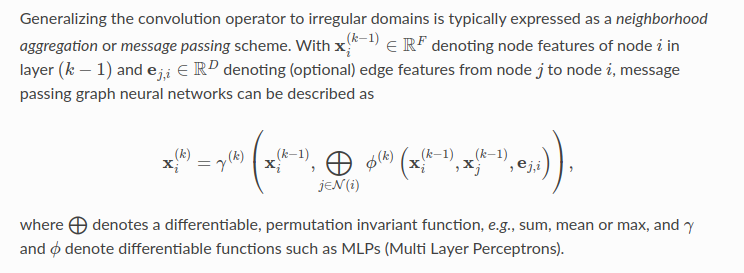

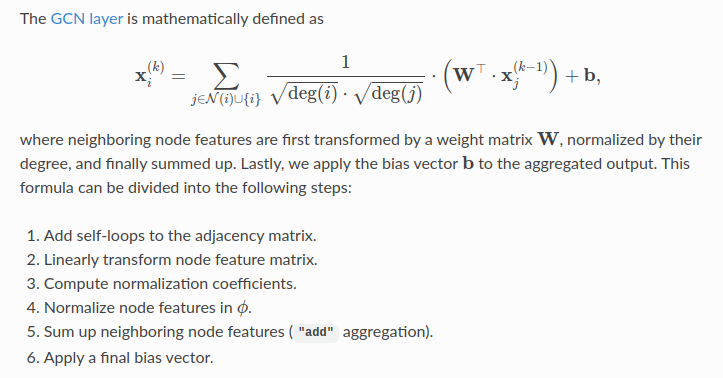

In [3]:
# import PPI dataset
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

# Load the PPI dataset
path = '/tmp/PPI'
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')



Extracting \tmp\PPI\ppi.zip
Processing...
Done!


In [4]:
# Create a DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# print examples of the dataset
for data in train_loader:
    x, edge_index = data.x, data.edge_index
    break

In [5]:
x.shape, edge_index.shape

(torch.Size([24047, 50]), torch.Size([2, 670702]))

In [4]:
input_features = x.shape[1]
output_features = 256
layer = GINLayer(input_features, output_features, aggr='sum')
print(x.shape)
layer.propagate(x, edge_index).shape

torch.Size([1767, 50])


torch.Size([1767, 256])

In [6]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch = batch.to(device)
            output = model(batch.x, batch.edge_index)
            loss_test = loss_fcn(output, batch.y)
            predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
            score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
            score_list_batch.append(score)

            del batch
            del output
            del loss_test
            torch.cuda.empty_cache()

    return np.array(score_list_batch).mean()

In [11]:
class GraphGIN(nn.Module):
    def __init__(self, input_features, hidden_features, output_features, num_layers):
        super(GraphGIN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GINLayer(input_features, hidden_features, aggr='sum', eps=0.))
        for _ in range(num_layers - 2):
            self.layers.append(GINLayer(hidden_features, hidden_features, aggr='sum', eps=0.))
        self.layers.append(GINLayer(hidden_features, output_features, aggr='sum', activation=False, eps=0.))
        
    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer.propagate(x, edge_index)
        return x
    

def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader,
    save_best=False
):

    best_model_state_dict = None
    best_score = 0

    epoch_list = []
    scores_list = []

    # loop over epochs
    with tqdm(range(max_epochs), unit='epoch') as t:
        for epoch in range(max_epochs):
            model.train()
            losses = []
            # loop over batches
            for i, train_batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                train_batch_device = train_batch.to(device)
                # logits is the output of the model
                logits = model(train_batch_device.x, train_batch_device.edge_index)
                # compute the loss
                loss = loss_fcn(logits, train_batch_device.y)
                # optimizer step
                loss.backward()
                optimizer.step()
                losses.append(loss.cpu().detach().item())

                



            loss_data = np.array(losses).mean()

            # evaluate the model on the validation set
            score = evaluate(model, loss_fcn, device, val_dataloader)
            if score > best_score:
                best_score = score
                if save_best:
                    best_model_state_dict = deepcopy(model.state_dict())
                    
            t.set_postfix(loss=loss_data, f1=score)
            t.update(1)
   
            scores_list.append(score)
            epoch_list.append(epoch)

            del train_batch_device
            del logits
            del loss
            torch.cuda.empty_cache()


    # Load the best model state
    if save_best and best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
        print('Best model loaded')


    return epoch_list, scores_list


In [12]:
# ### DEVICE GPU OR CPU : will select GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("\nDevice: ", device)

# ### Max number of epochs
# max_epochs = 800

# ### Number of features
# n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]
# hidden_size = 256

# ### DEFINE THE MODEL
# basic_model = GraphSAGE(n_features, hidden_size, n_classes, num_layers=2).to(device)

# ### DEFINE LOSS FUNCTION
# loss_fcn = nn.BCEWithLogitsLoss()

# ### DEFINE OPTIMIZER
# optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=0.0001)

# ### TRAIN THE MODEL
# epoch_list, basic_model_scores = train(
#     basic_model,
#     loss_fcn,
#     device,
#     optimizer,
#     max_epochs,
#     train_loader,
#     val_loader,
# )

In [13]:
# # evaluate the model on the test set
# test_score = evaluate(basic_model, loss_fcn, device, test_loader)
# print(f"Test F1-score: {test_score}")

In [14]:
from copy import deepcopy
import pandas as pd

In [15]:
# gather all data in one dataset (train/val/test)   
all_data = train_dataset + val_dataset + test_dataset
all_loader = DataLoader(all_data, batch_size=2, shuffle=False)

### Max number of epochs
max_epochs = 300

### Number of features
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)


# for k in range(1, 10): perform K fold seperation of the data into test and train_out
K = 12
best_score = 0
best_model = None
best_hyperparameters = None
results = pd.DataFrame(columns=['K', 'valid_score', 'test_score', 'lr', 'num_layers', 'hidden_size'])
all_data = train_dataset + val_dataset + test_dataset
for k in range(K):
    print(f"K-Fold: {k+1}/{K}")
    # split the data into train and test
    n = len(all_data)//K 
    test_range_index = np.arange(k*n, (k+1)*n)
    # all the rest for train
    train_range_index = np.setdiff1d(np.arange(len(all_data)), test_range_index)
    train_out = torch.utils.data.Subset(all_data, train_range_index)
    test = torch.utils.data.Subset(all_data, test_range_index)

    # randomly choose 20% of the train_out data to be the validation set
    n = len(train_out)//5
    val_range_index = np.random.choice(len(train_out), n, replace=False)
    val = torch.utils.data.Subset(train_out, val_range_index)
    train_in = torch.utils.data.Subset(train_out, np.setdiff1d(np.arange(len(train_out)), val_range_index))

    

    # create the dataloader
    train_in_loader = DataLoader(train_in, batch_size=2, shuffle=True)
    val_loader = DataLoader(val, batch_size=2, shuffle=False)
    test_loader = DataLoader(test, batch_size=2, shuffle=False)

    # define hyperparameters grid
    hyperparameters = {
        'lr': [0.1, 0.01],
        'num_layers': [2],
        'hidden_size': [256, 512, 1024]
    }

    best_score = 0
    for lr in hyperparameters['lr']:
        for num_layers in hyperparameters['num_layers']:
            for hidden_size in hyperparameters['hidden_size']:
                print(f"lr: {lr}, num_layers: {num_layers}, hidden_size: {hidden_size}")
                ### DEFINE THE MODEL
                basic_model = GraphGIN(n_features, hidden_size, n_classes, num_layers).to(device)

                ### DEFINE LOSS FUNCTION
                loss_fcn = nn.BCEWithLogitsLoss()

                ### DEFINE OPTIMIZER
                optimizer = torch.optim.Adam(basic_model.parameters(), lr=lr)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=0.0001)

                ### TRAIN THE MODEL
                epoch_list, basic_model_scores = train(
                    basic_model,
                    loss_fcn,
                    device,
                    optimizer,
                    max_epochs,
                    train_in_loader,
                    val_loader,
                    save_best=True
                )

                # evaluate the model on the test set
                valid_score = evaluate(basic_model, loss_fcn, device, val_loader)
                print(f"Valid F1-score: {valid_score}")

                # save the best model
                if valid_score > best_score:
                    best_score = valid_score
                    del best_model
                    best_model = deepcopy(basic_model)
                    best_hyperparameters = {
                        'lr': lr,
                        'num_layers': num_layers,
                        'hidden_size': hidden_size
                    }
                results.loc[len(results.index)] = [k, valid_score, 0, lr, num_layers, hidden_size]

                del basic_model
                del optimizer
                del scheduler
                torch.cuda.empty_cache()
                

    # evaluate the best model on the test set
    test_score = evaluate(best_model, loss_fcn, device, test_loader)
    print(f"Test F1-score: {test_score}")

    # save the results in dataframe
    results.loc[len(results.index)] = [k, best_score, test_score, best_hyperparameters['lr'], best_hyperparameters['num_layers'], best_hyperparameters['hidden_size']]

# save the results in a csv file
results.to_csv('results.csv', index=False)


Device:  cuda
K-Fold: 1/12
lr: 0.1, num_layers: 2, hidden_size: 256


100%|██████████| 300/300 [03:42<00:00,  1.35epoch/s, f1=0.577, loss=0.447]


Best model loaded
Valid F1-score: 0.6240875902940943
lr: 0.1, num_layers: 2, hidden_size: 512


100%|██████████| 300/300 [06:59<00:00,  1.40s/epoch, f1=0.606, loss=0.435]


Best model loaded
Valid F1-score: 0.6439469471394391
lr: 0.1, num_layers: 2, hidden_size: 1024


 37%|███▋      | 110/300 [16:31<30:26,  9.61s/epoch, f1=0.554, loss=0.665]

In [15]:
results[results['test_score']>0.].test_score.mean()

0.9258662229112695

In [16]:
results[results['test_score']>0.].test_score.std()

0.03848616948732571

In [ ]:
# test pygeometric implementation of grpahsage
from torch_geometric.nn import SAGEConv

class GraphSAGEPyG(nn.Module):
    def __init__(self, input_features, hidden_features, output_features, num_layers):
        super(GraphSAGEPyG, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(input_features, hidden_features))
        for _ in range(num_layers - 2):
            self.layers.append(SAGEConv(hidden_features, hidden_features))
        self.layers.append(SAGEConv(hidden_features, output_features))
        
    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)
        return x
    
### DEFINE THE MODEL
pyg_model = GraphSAGEPyG(n_features, hidden_size, n_classes, num_layers=3).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(pyg_model.parameters(), lr=0.001)

### TRAIN THE MODEL
epoch_list, pyg_model_scores = train(
    pyg_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_loader,
    val_loader,
)


  0%|          | 0/200 [00:00<?, ?epoch/s]

100%|██████████| 200/200 [01:07<00:00,  2.95epoch/s, f1=0.495, loss=0.498]


In [ ]:
# evaluate the model on the test set
pyg_model_score = evaluate(pyg_model, loss_fcn, device, test_loader)

print("PyG Model F1-Score: ", pyg_model_score)

PyG Model F1-Score:  0.509152857364101


In [ ]:
# pytorch geometric GIN implementation

from torch_geometric.nn import GINConv

class GIN(nn.Module):
    def __init__(self, input_features, hidden_features, output_features, num_layers):
        super(GIN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GINConv(nn.Sequential(nn.Linear(input_features, hidden_features), nn.ReLU()), train_eps=True))
        for _ in range(num_layers - 2):
            self.layers.append(GINConv(nn.Sequential(nn.Linear(hidden_features, hidden_features), nn.ReLU()), train_eps=True))
        self.layers.append(GINConv(nn.Sequential(nn.Linear(hidden_features, output_features)),train_eps=True))
        
    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)
        return x
    
### DEFINE THE MODEL
gin_model = GIN(n_features, hidden_size, n_classes, num_layers=3).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(gin_model.parameters(), lr=0.0001)

### TRAIN THE MODEL
epoch_list, gin_model_scores = train(
    gin_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_loader,
    val_loader,
)

# evaluate the model on the test set
gin_model_score = evaluate(gin_model, loss_fcn, device, test_loader)

print("GIN Model F1-Score: ", gin_model_score)

100%|██████████| 200/200 [01:01<00:00,  3.28epoch/s, f1=0.429, loss=0.614]

GIN Model F1-Score:  0.4302386017697401
